# Data Preparation

In [84]:
from pandas import DataFrame
from datetime import datetime

In [85]:
class MVTSSample:
    
    def __init__(self, active_region:str, flare_class:str, flare_type:str, \
                 verification:str, start_time:datetime, end_time:datetime, data:DataFrame):
        self.flare_type = flare_type
        self.active_region = active_region
        self.flare_class = flare_class
        self.verification = verification
        self.start_time = start_time
        self.end_time = end_time
        self.data = data
    
    def get_flare_type(self):
        return self.flare_type
    
    def get_flare_class(self):
        return self.flare_class
    
    def get_active_region(self):
        return self.active_region
    
    def get_verification(self):
        return self.verification
    
    def get_start_time(self):
        return self.start_time
    
    def get_end_time(self):
        return self.end_time
    
    def get_data(self):
        return self.data

In [86]:
import os
import pandas as pd

In [133]:
def read_mvts_instance(data_dir:str, file_name:str) -> MVTSSample: #Finished!
    # Get flare type from file name
    if file_name[0:1] == 'F' :
        flare_type = file_name[0:2]
    else:
        flare_type = file_name[0:4]
    active_region = file_name[file_name.find('_ar')+3: file_name.find('_s2')]
    
    verification = 'FQ'
    flare_class = 'FQ'
    if file_name[0:1] != 'F' :
        verification = file_name.split(':')[1].split('_')[0]
        flare_class = file_name[0:1]
    

    try:
        # Get start time from file name
        start = file_name.find('s2')
        start_time = file_name[start+1: start+20]
        start_time = start_time.replace("T", " ")
        start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")

        # Get end time from file name
        end = file_name.find('e2')
        end_time = file_name[end+1: end+20]
        end_time = end_time.replace("T", " ")
        end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        print(ValueError)
        pass

    # Get data from csv file
    try:
        data = pd.read_csv(data_dir + "/" + file_name, sep="\t")
        data['Timestamp'] = data['Timestamp'].str.replace('-', '')
        data['Timestamp'] = data['Timestamp'].str.replace(' ', '')
        data['Timestamp'] = data['Timestamp'].str.replace(':', '')
    except ValueError:
        print(ValueError)
        pass
    
    # Make mvts object 
    mvts = MVTSSample(active_region, flare_class, flare_type, verification, start_time, end_time, data)
    return mvts

In [88]:
import numpy as np

In [90]:
from os import listdir

In [157]:
import csv
import numpy as np
import pickle
from tqdm import tqdm


def process_partition(partition_location:str, abt_name:str):
    abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']
    
    abt_header_label = ['FLARE_CLASS', 'FLARE_TYPE', 'ACTIVE_REGION', 'VERIFICATION']
    
    abt_label = pd.DataFrame(columns=abt_header_label)
    

    # Get lists of data from partition
    FL = os.listdir(partition_location + "/FL")
    NF = os.listdir(partition_location + "/NF")
    
    number_of_features=25
    number_of_timestamps=60
    abt = np.zeros((number_of_timestamps,number_of_features,len(FL + NF)))
    
    count = 0
    # Add row to abt from mvssample object and its median and std data
    with tqdm(len(FL + NF)) as pbar:

        for d in FL + NF:

            # Use temp list for each row and temp df
            list2add_label = []
            tempdf = pd.DataFrame(columns=abt_header)
            tempdf_label = pd.DataFrame(columns=abt_header_label)

            # Get mvs object and add flare type 
            if d in FL:
                mvs = read_mvts_instance(partition_location + '/FL', d)
            else:
                mvs = read_mvts_instance(partition_location + '/NF', d)
            list2add_label.append(mvs.get_flare_class())
            list2add_label.append(mvs.get_flare_type())
            list2add_label.append(mvs.get_active_region())
            list2add_label.append(mvs.get_verification())


            # Set up temp df for future concat with master data frame object
            templist = mvs.get_data()[abt_header]
            templist = templist.to_numpy()

            # From data frame concat current with temp for each feature 
            abt[:,:,count] = templist

            tempdf_label.loc[len(abt_header_label)] = list2add_label
            abt_label = pd.concat([abt_label, tempdf_label], ignore_index= True, axis = 0)


            count +=1
            pbar.update(1)
            #if count >= 1000:
                #break
            #continue
            

    print(abt_name)        
    print("shape: " + str(abt.shape))
    with open(abt_name + ".pkl", 'wb') as f:
        pickle.dump(abt, f)
        
    abt_label.to_csv(abt_name + "_labels.csv", index=False, header=True)
    # return the completed analitics base table
    return abt_label

# Data Exploration

In [158]:

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/Data"  
# change the path to where your data is stored.


for i in range(1,6):
    abt_name = "partition" + str(i) # Corrected to partition 1
    abt = process_partition(data_dir + "/" + "partition" + str(i), abt_name)
    print("number of instances: " + str(abt.shape[0]))
    print(abt.head(5))
    print('\n')

73492it [03:26, 355.07it/s]


partition1
shape: (60, 25, 73492)
number of instances: 73492
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.0           115      Primary
1           M       M2.0            54      Primary
2           M       M1.3           384      Primary
3           M       M3.5           753      Primary
4           M       M1.0           437      Primary




88557it [04:32, 325.36it/s]


partition2
shape: (60, 25, 88557)
number of instances: 88557
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M5.7          1638      Primary
1           M       M2.8          1461      Primary
2           M       M1.0          1603      Primary
3           M       M5.7          1638      Primary
4           M       M1.9          1621      Primary




42510it [01:53, 374.49it/s]


partition3
shape: (60, 25, 42510)
number of instances: 42510
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.6          3497      Primary
1           M       M1.0          3688    Secondary
2           M       M1.3          4186      Primary
3           M       M2.5          3341      Primary
4           M       M2.3          3721      Primary




51261it [02:21, 361.70it/s]


partition4
shape: (60, 25, 51261)
number of instances: 51261
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.3          4874      Primary
1           X       X1.6          4781      Primary
2           M       M1.6          4920      Primary
3           M       M1.2          4344      Primary
4           M       M1.4          4294      Primary




75365it [17:45, 70.72it/s] 


partition5
shape: (60, 25, 75365)
number of instances: 75365
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M6.5          5692      Primary
1           M       M5.5          5983      Primary
2           M       M1.0          6327      Primary
3           M       M1.0          5885      Primary
4           M       M1.1          6015      Primary




# Class Distribution

In [141]:
import pandas as pd
labels = []
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/"

for i in range(1,6):
    labels.append(pd.read_csv(data_dir + "partition" + str(i) + "_labels.csv"))

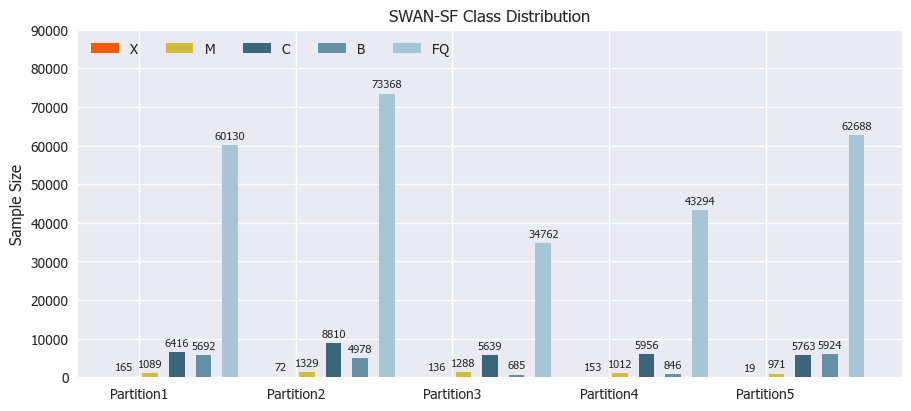

In [186]:
# Create dictionary for counts of each flare type
flare_types = {"X": [0,0,0,0,0], "M": [0,0,0,0,0], "C": [0,0,0,0,0], "B": [0,0,0,0,0], "FQ": [0,0,0,0,0]}

plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

color = ['#f95a00','#d1bc3f','#3b657b','#6590a6','#a6c5d5']
    
for i in range(1,6):

    # For each objects flare type sort into M, X, C, B, or FQ, otherwise skip
    for j in labels[i-1]['FLARE_TYPE']:
        if "M" in j:
            flare_types["M"][i-1] +=1
        elif "X" in j:
            flare_types["X"][i-1] +=1
        elif "C" in j:
            flare_types["C"][i-1] +=1
        elif "B" in j:
            flare_types["B"][i-1] +=1
        elif "FQ" in j:
            flare_types["FQ"][i-1] +=1
        else:
            continue


group = ("Partition1", "Partition2", "Partition3", "Partition4", "Partition5")

x = np.arange(len(group))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', sharey=True,
  figsize=(9, 4))

for attribute, measurement in flare_types.items():
    offset = width * multiplier * 1.7
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = color[multiplier] )
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sample Size')
ax.set_title('SWAN-SF Class Distribution')
ax.set_xticks(x + width, group)
ax.legend(loc='upper left', ncols=5)
ax.set_ylim(0, 90000)

plt.show()

# Missing value Exploration

In [184]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [26]:
abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

null_count = [0,0,0,0,0]
non_null_count = [0,0,0,0,0]
null_count_per_feature = np.zeros((5,125), dtype=int)

for i in range(1,6):
    partition = np.array(data[i-1])
    
    for j in range(1,partition.shape[2]):
        mvts = partition[:,:, j-1]
        for m in range(1,26):
            for n in range (1,61):
                if (mvts[n-1,m-1] == 0.0):
                    null_count[i-1] += 1
                    null_count_per_feature[i-1,m-1] += 1
                else:
                    non_null_count[i-1] += 1
    
    print("Partition" + str(i) + ":")
    print("null counts in P" + str(i) + ": " + str(null_count[i-1]))
    print("non-null counts in P"+ str(i) + ": " + str(non_null_count[i-1]))
    for x in range(1,26):
        print(abt_header[x-1] + ": " + str(null_count_per_feature[i-1,x-1]))
    
    print("\n")

Partition1:
null counts in P1: 2487130
non-null counts in P1: 107749370
Timestamp: 0
R_VALUE: 2399204
TOTUSJH: 652
TOTBSQ: 652
TOTPOT: 652
TOTUSJZ: 652
ABSNJZH: 652
SAVNCPP: 652
USFLUX: 652
TOTFZ: 652
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 81406
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 652
MEANJZD: 0
MEANALP: 0
TOTFX: 652


Partition2:
null counts in P2: 4002443
non-null counts in P2: 128831557
Timestamp: 0
R_VALUE: 2934858
TOTUSJH: 93300
TOTBSQ: 93300
TOTPOT: 93300
TOTUSJZ: 93300
ABSNJZH: 93300
SAVNCPP: 93300
USFLUX: 93300
TOTFZ: 93300
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 134585
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 93300
MEANJZD: 0
MEANALP: 0
TOTFX: 93300


Partition3:
null counts in P3: 1472336
non-null counts in P3: 62291164
Timestamp: 0
R_VALUE: 1361036
TOTUSJH: 2718
TOTBSQ: 2718
TOTPOT: 2718
TOTUSJZ: 2718
ABSNJZH: 2718
SAVNCPP: 2725
USFLUX: 2718
TOTFZ: 2718
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0

# MVTS visualization

In [36]:
sample_flare_index = [0,0,0]

for i in range(0,len(labels[0]['FLARE_CLASS'])):
    if labels[0]['FLARE_CLASS'][i] == 'X':
        sample_flare_index[0] = i
    elif labels[0]['FLARE_CLASS'][i] == 'M':
        sample_flare_index[1] = i
    elif labels[0]['FLARE_CLASS'][i] == 'C':
        sample_flare_index[2] = i
    
    count = 0
    for j in range(0,3):
        if sample_flare_index[j] != 0:
            count += 1
    if count == 3:
        break
       

In [136]:
from scipy.stats import zscore

def plot_time_series_class(data, timestamp, class_name, ax, n_steps=5):
    
    time_series_df = pd.DataFrame(data)
    
    time_series_df[0] = zscore(time_series_df[0])
    time_series_df[1] = zscore(time_series_df[1])
    time_series_df[2] = zscore(time_series_df[2])

    smooth_path = time_series_df[0].rolling(n_steps).mean()
    ax.plot(smooth_path, linestyle='-', linewidth=1, label='X Flare', color='#f95a00')
    
    smooth_path = time_series_df[1].rolling(n_steps).mean()
    ax.plot(smooth_path, linestyle='-', linewidth=1, label='M Flare', color='#d1bc3f')
    
    smooth_path = time_series_df[2].rolling(n_steps).mean()
    ax.plot(smooth_path, linestyle='-', linewidth=1, label='C Flare', color='#3b657b')
    

    ax.set_ylabel(class_name)
    ax.legend();

Class: X
Start Time: 2011-03-09 01:36  and  End Time: 2011-03-09 13:24
Class: M
Start Time: 2011-10-01 09:36  and  End Time: 2011-10-01 21:24
Class: C
Start Time: 2011-08-03 07:12  and  End Time: 2011-08-03 19:00


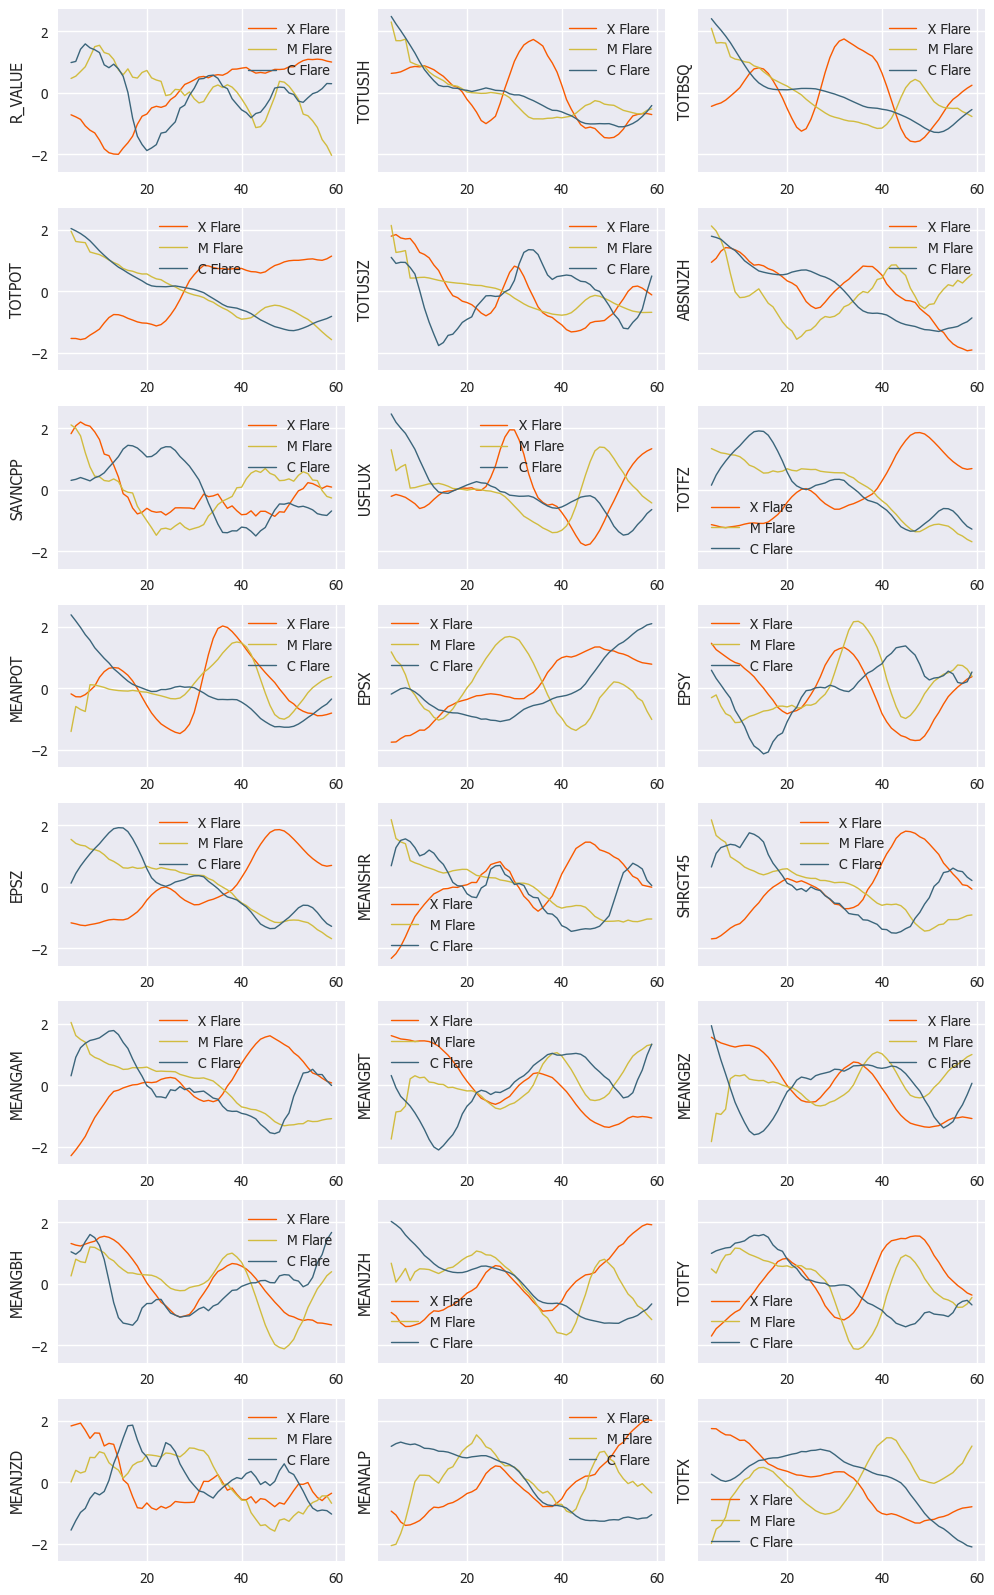

In [185]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

abt_header = ['R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

fig, axs = plt.subplots(8,3, sharey=True,
  figsize=(10, 16))

sample_flare_mvts = np.zeros((60,25,3))

for i in range(0,3):
    sample_flare_mvts[:,:, i] = np.array(data[0])[:,:, sample_flare_index[i]]
    
    timestamp = sample_flare_mvts[:,0, i]

    start_time = str(timestamp[0])[0:4] + '-' + str(timestamp[0])[4:6] + '-' + str(timestamp[0])[6:8] \
                + ' ' + str(timestamp[0])[8:10] + ":" + str(timestamp[0])[10:12]

    end_time = str(timestamp[59])[0:4] + '-' + str(timestamp[59])[4:6] + '-' + str(timestamp[59])[6:8] \
                + ' ' + str(timestamp[59])[8:10] + ":" + str(timestamp[59])[10:12]

    if i == 0:
        print('Class: X') 
    elif i == 1:
        print('Class: M') 
    else:
        print('Class: C') 
        
    print('Start Time: ' + start_time + '  and  End Time: ' + end_time)



for i, cls in enumerate(abt_header):
    ax = axs.flat[i]
    data = sample_flare_mvts[:,i+1,:]
    
    plot_time_series_class(data, timestamp, abt_header[i], ax)

fig.tight_layout();
    

# KNN Imputation 

In [15]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

from tqdm import tqdm

for i in range(0,5):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = np.array(data[i])[:,:,j]
            for m in range(0,24):
                new_column[:,m+1][new_column[:,m+1] == 0] = np.nan
                new_2d = new_column[:,m+1].reshape(len(new_column[:,m+1]), 1)
                new_column[:,m+1] = imputer.fit_transform(new_2d)[:,0]
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open("partition" + str(i+1) + "_imputed" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

3it [00:00,  9.68it/s]

[3.90609933 3.89165263 3.93265495 3.93417022 3.94940102 3.89834397
 3.79557531 3.80708906 3.80975378 3.8058777  3.79849441 3.84831739
 3.86554521 3.8727296  3.82782182 3.83101046 3.85039228 3.84028628
 3.8742274  3.90208926 3.8996535  3.84691756 3.90724828 3.95012761
 3.92519431 3.8910777  3.93023126 3.83600468 3.92548334 3.90850284
 3.84466859 3.92362122 3.86963397 3.8103784  3.66969604 3.86481226
 3.8073445  3.75618836 3.73257913 3.72862272 3.68563157 3.69152501
 3.73932766 3.76915779 3.74677887 3.7731778  3.7737566  3.77207773
 3.77441439 3.82094587 3.75325058 3.81316102 3.58893125 3.7000903
 3.70331988 3.62468789 3.62601422 3.58070908 3.58158569 3.62220717]
[3.90609933 3.89165263 3.93265495 3.93417022 3.94940102 3.89834397
 3.79557531 3.80708906 3.80975378 3.8058777  3.79849441 3.84831739
 3.86554521 3.8727296  3.82782182 3.83101046 3.85039228 3.84028628
 3.8742274  3.90208926 3.8996535  3.84691756 3.90724828 3.95012761
 3.92519431 3.8910777  3.93023126 3.83600468 3.92548334 3.9085

5it [00:00, 10.43it/s]

[5.07820599 5.10462345 5.11689248 5.119985   5.12929217 5.1228489
 5.080302   5.09017127 5.08048464 5.10146135 5.07828657 5.06674792
 5.08995402 5.09342235 5.11385049 5.10303393 5.09590164 5.08664097
 5.09219558 5.06170731 5.06414536 5.06154587 5.07503122 5.0757794
 5.0803066  5.0556859  5.06519995 5.06230063 5.05038566 5.06304244
 5.04148996 5.01842063 5.03382761 5.04631984 5.05403501 5.04934158
 5.07165753 5.07551641 5.05469467 5.05202085 5.06083417 5.03908664
 5.04839561 5.03137208 5.05503896 5.05705042 5.07800729 5.04555792
 5.0497826  5.04794874 5.05851845 5.05674984 5.0664518  5.07092107
 5.0683487  5.04962074 5.04433029 5.07072134 5.08368201 5.09814299]
[5.07820599 5.10462345 5.11689248 5.119985   5.12929217 5.1228489
 5.080302   5.09017127 5.08048464 5.10146135 5.07828657 5.06674792
 5.08995402 5.09342235 5.11385049 5.10303393 5.09590164 5.08664097
 5.09219558 5.06170731 5.06414536 5.06154587 5.07503122 5.0757794
 5.0803066  5.0556859  5.06519995 5.06230063 5.05038566 5.0630424

9it [00:00, 11.18it/s]

[5.28860473 5.28984051 5.2865708  5.29695018 5.29391216 5.29249442
 5.29004456 5.29024592 5.28185863 5.28363906 5.28981543 5.2951885
 5.27958042 5.27084728 5.25203621 5.25794574 5.25143314 5.21731828
 5.20613761 5.22140781 5.22913113 5.2448746  5.2440738  5.23121549
 5.23726919 5.2364954  5.20824383 5.23909461 5.2659424  5.27301037
 5.24828683 5.26115251 5.24773923 5.2149095  5.21182736 5.20958009
 5.20606257 5.23204354 5.2097905  5.21135114 5.21123929 5.23189282
 5.24297269 5.23091792 5.217798   5.20372431 5.20510004 5.21985241
 5.20707716 5.21383578 5.20978295 5.23586734 5.22023012 5.25640061
 5.22396401 5.22073236 5.24622859 5.21534068 5.23177029 5.24062281]
[5.28860473 5.28984051 5.2865708  5.29695018 5.29391216 5.29249442
 5.29004456 5.29024592 5.28185863 5.28363906 5.28981543 5.2951885
 5.27958042 5.27084728 5.25203621 5.25794574 5.25143314 5.21731828
 5.20613761 5.22140781 5.22913113 5.2448746  5.2440738  5.23121549
 5.23726919 5.2364954  5.20824383 5.23909461 5.2659424  5.27301

9it [00:00,  9.69it/s]


KeyboardInterrupt: 

# Z Normalization

In [10]:
from scipy.stats import zscore
from tqdm import tqdm

for i in range(0,5):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = np.array(data[i])[:,:,j]
            for m in range(0,24):
                new_column[:,m+1] = zscore(new_column[:,m+1])
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open("partition" + str(i+1) + "_normalized" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

        
                   

3it [00:00, 10.46it/s]

[2.01008070e+13 2.01008070e+13 2.01008070e+13 2.01008070e+13
 2.01008070e+13 2.01008070e+13 2.01008070e+13 2.01008070e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008072e+13 2.01008072e+13 2.01008072e+13]
[ 1.00995061  0.86296056  1.28014453  1.29556192  1.45052985  0.93104256
 -0.1145919

5it [00:00, 11.15it/s]

[2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13]
[ 0.31700804  1.42124104  1.93407876  2.06334409  2.45237765  2.18305329
  0.4046202

8it [00:00, 10.03it/s]

[2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13]
[ 1.53670122  1.57839273  1.46808285  1.81825177  1.71575793  1.66792763
  1.5852770

KeyboardInterrupt: 

# Train Test Split

Partition 1 to 3: Train, Partition 4: Validation, and Partition5: Test

# First round ML

ROCKET, LSTM, GRU, RNN, TSF

In [ ]:
# ROCKET

In [ ]:
# LSTM

In [ ]:
# GRU

# Undersampling and Oversampling

SMOTE, ADASYN, TimeGAN, Noise Injection | RSU

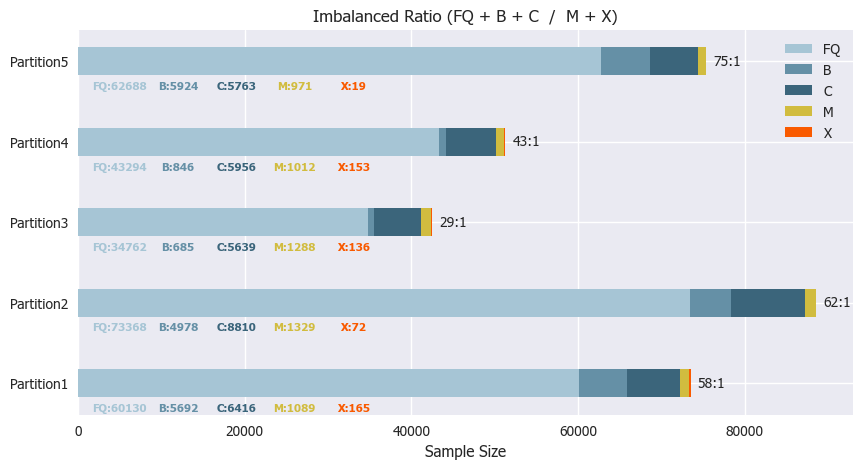

In [209]:
flare_types = {"FQ": [0,0,0,0,0], "B": [0,0,0,0,0], "C": [0,0,0,0,0], "M": [0,0,0,0,0], "X": [0,0,0,0,0]}
imbalanced = {1: [0,0], 2: [0,0], 3: [0,0], 4: [0,0], 5: [0,0]}

plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

color = ['#a6c5d5','#6590a6','#3b657b','#d1bc3f','#f95a00']
group = ["Partition1", "Partition2", "Partition3", "Partition4", "Partition5"]

    
for i in range(1,6):

    # For each objects flare type sort into M, X, C, B, or FQ, otherwise skip
    for j in labels[i-1]['FLARE_TYPE']:
        if "M" in j:
            flare_types["M"][i-1] +=1
            imbalanced[i][0] +=1
        elif "X" in j:
            flare_types["X"][i-1] +=1
            imbalanced[i][0] +=1
        elif "C" in j:
            flare_types["C"][i-1] +=1
            imbalanced[i][1] +=1
        elif "B" in j:
            flare_types["B"][i-1] +=1
            imbalanced[i][1] +=1
        elif "FQ" in j:
            flare_types["FQ"][i-1] +=1
            imbalanced[i][1] +=1
        else:
            continue

            
fig, ax = plt.subplots(sharey=True,
  figsize=(10, 5))

left = np.zeros(len(flare_types.keys()))

for i, col in enumerate(flare_types.keys()):
    ax.barh(
        group, flare_types[col], height=0.35, left=left, label=col, color=color[i])
    left += np.array(flare_types[col])
    
    

totals = [0,0,0,0,0]
for i in range(0,5):
    totals[i] = flare_types['FQ'][i] + flare_types['B'][i] + flare_types['C'][i] + flare_types['M'][i] + \
    flare_types['X'][i]
    
y_offset = 2500
x_offset = - 0.05
for i, total in enumerate(totals):
    ax.text(total + y_offset, i + x_offset, str(str(round(imbalanced[i+1][1] / imbalanced[i+1][0]))+":1"),
            ha='center', weight='normal', size=10)

# Let's put the annotations inside the bars themselves by using a
# negative offset.
x_offset = -0.35
y_offset = -2000
# For each patch (basically each rectangle within the bar), add a label.

# For each patch (basically each rectangle within the bar), add a label.
count = 0
color_number = 0
for bar in ax.patches:
    if count == 5:
        color_number += 1
        count = 0
    count += 1
        
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      5000 + color_number * 7000,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_y() + bar.get_height() / 2 + x_offset,
      # This is actual value we'll show.
      list(flare_types.keys())[color_number] + ':' + str(int(bar.get_width())),
      # Center the labels and style them a bit.
      ha='center',
      color=color[color_number],
      weight='bold',
      size=8
  )

ax.set_title("Imbalanced Ratio (FQ + B + C  /  M + X)")
ax.set_xlabel('Sample Size')
    
ax.legend()

In [94]:
# SMOTE and RUS

In [ ]:
# ADASYN and RUS

In [ ]:
# Noise Injection and RUS

# Second round ML

ROCKET, LSTM, GRU, RNN, TSF (On Augmented data)

In [ ]:
# ROCKET (SMOTE and RUS)
from sktime.transformations.panel.rocket import Rocket


In [ ]:
# ROCKET (ADASYN and RUS)

In [ ]:
# LSTM (SMOTE and RUS)

In [ ]:
# LSTM (ADASYN and RUS)

In [ ]:
# GRU (SMOTE and RUS)

In [ ]:
# GRU (ADASYN and RUS)

# Comparison

# Final Visualizations